# Play with NLP
*from https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py*

In [2]:
from sklearn.datasets import fetch_openml
from sklearn import datasets, svm, metrics
from pandas import DataFrame
import spacy
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/idvorkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# make the plot wider
height_in_inches=8
matplotlib.rc("figure", figsize=(2*height_in_inches,height_in_inches))

In [4]:
import glob
import os 
from nltk.tokenize import word_tokenize 

# Load corpus of my daily ramblings
mypath = os.path.expanduser("~/gits/igor2/750words/*md")
files = glob.glob(mypath)
data = ""
for file_name in files:
      with open (file_name) as myfile:
            data += str(myfile.read())
            
words = data.lower(). \
    replace(","," ").replace("."," ") \
    .split()

# clean up words that don't help analysis.
remove_words = set(" yes yup Disciplined Daily Know Affirmations Deliberate Essential get that's - ".lower().split(" "))
words = [word for word in words if not word in stops and not word in remove_words]


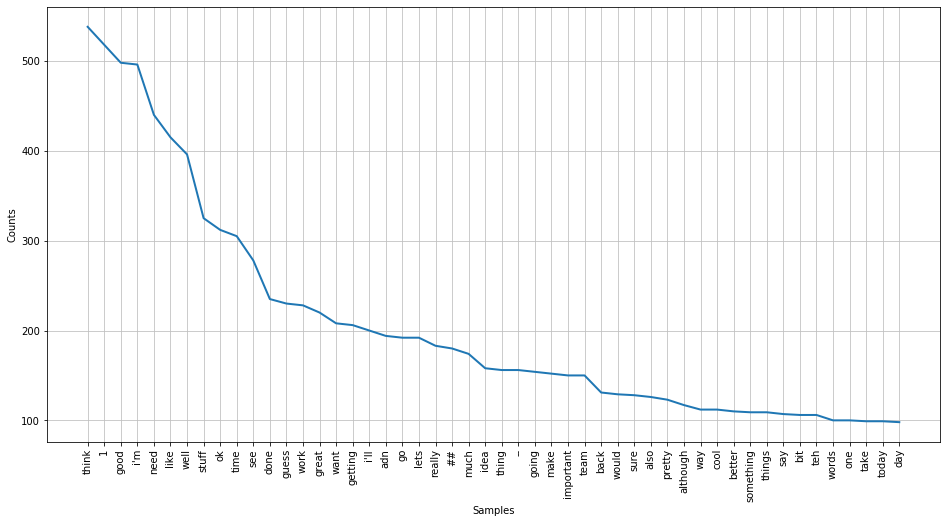

In [5]:
fd = nltk.FreqDist(words)
fd.plot(50, percents=True)

In [6]:
pd = DataFrame(words, columns=["word"])
pd.head()

,word
0,750
1,words
2,for:2018-08-18
3,testing
4,we're


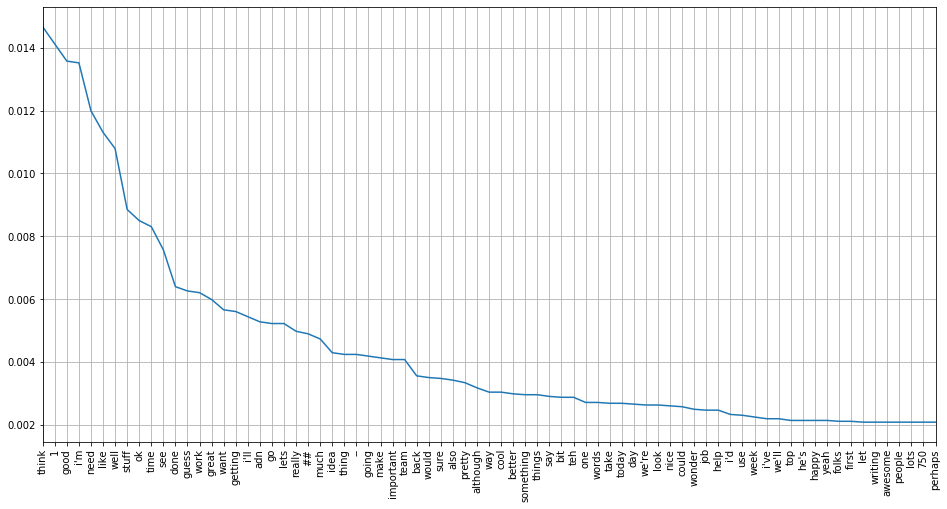

In [7]:
skip = 0
size = 75
pd["word"].value_counts(normalize=True).iloc[skip:skip+size] \
    .plot(rot=90, xticks=range(size), grid=True)

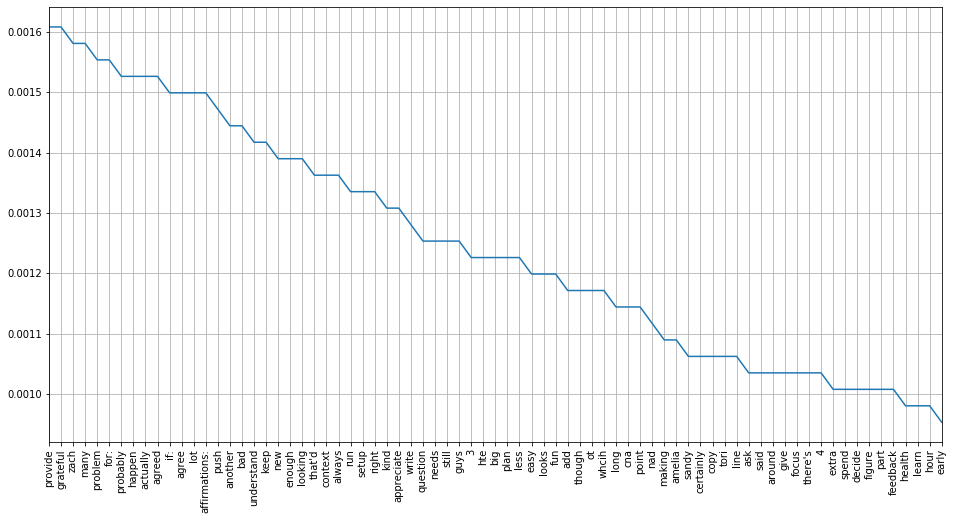

In [8]:
skip = 100
size = 75 
pd["word"].value_counts(normalize=True).iloc[skip:skip+size] \
    .plot(rot=90, xticks=range(size), grid=True)

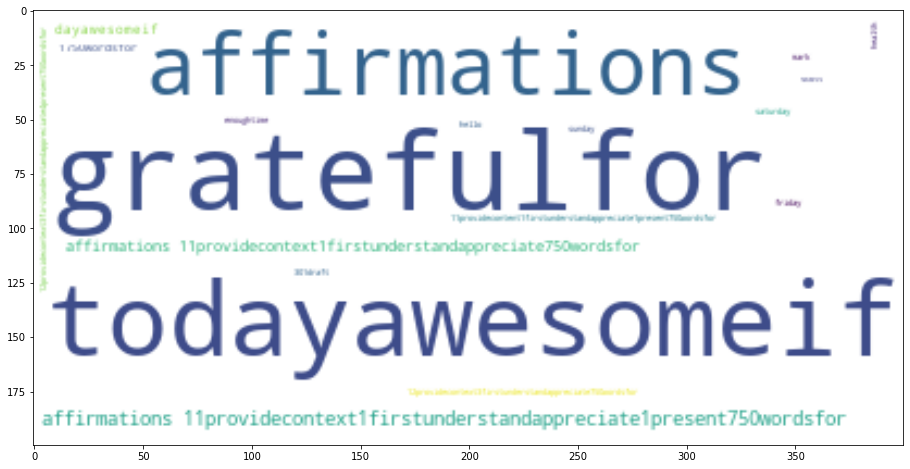

In [9]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=None).generate("".join(words))
plt.imshow(wordcloud,  interpolation='bilinear')

# Play with POS tagging and lemmatisation

In [50]:
# Load data model:
import spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")  # python -m spacy download en_core_web_sm
doc = nlp(" ".join(words))

In [63]:
max_to_analyze= 100
#interesting =  [token for token in  doc[:max_to_analyze] if token.pos_ == "NOUN"]
interesting =  [token for token in  doc[:max_to_analyze] if token.tag_ == "NNS"]
for token in interesting :
    # print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_) 


words word NOUN NNS nsubj
lines line NOUN NNS dobj
lines line NOUN NNS dobj
lots lot NOUN NNS amod
pages page NOUN NNS dobj
people people NOUN NNS compound
meetings meeting NOUN NNS dobj
folks folk NOUN NNS nsubj


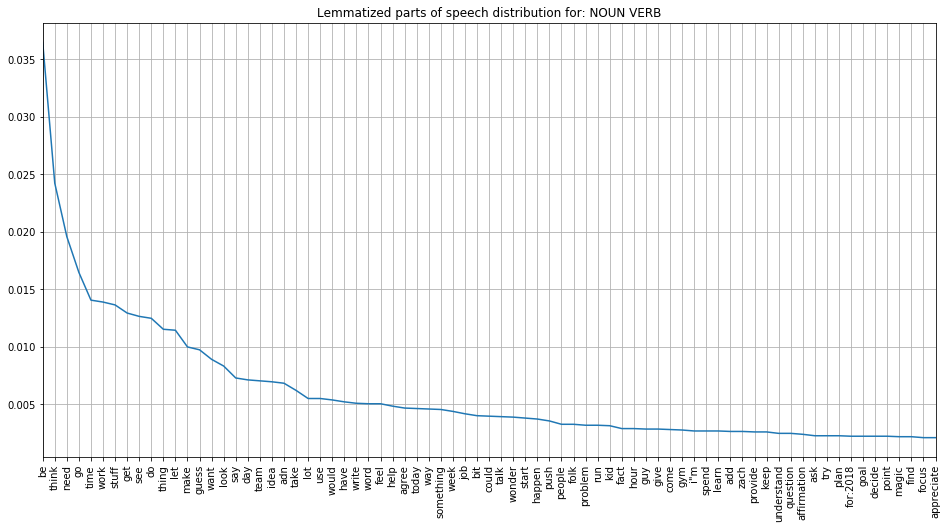

In [86]:
#interesting =  [token for token in  doc]
# interesting = [ token for token in doc if token.pos_ != "PUNCT" and token.pos_ != "SYM" and len(token.text) > 3] 

# Parts of speech: https://spacy.io/usage/linguistic-features
interesting_pos = "NOUN VERB"
interesting_post_set = set(interesting_pos.split())
interesting =  [token for token in  doc if token.pos_ in interesting_post_set]
interesting_words = [token.lemma_ for token in interesting ]

pd2 = DataFrame(interesting_words, columns="word".split())
(skip, size)  = (0, 75)
pd2["word"].value_counts(normalize=True).iloc[skip:skip+size] \
    .plot(rot=90, xticks=range(size), grid=True, title = f"Lemmatized parts of speech distribution for: {interesting_pos}")